In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json
from dateutil.parser import parse
import re
import matplotlib.pyplot as plt
import matplotlib
from xgboost import plot_importance
import requests
from sklearn.cross_validation import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import time
import datetime
from datetime import date
from bayes_opt import BayesianOptimization
from sklearn.cross_validation import cross_val_score
import numpy as np
import pytz
from sklearn.tree import DecisionTreeClassifier
import xml.etree.ElementTree as ET
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import urllib.parse
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from os import path


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
# {"querytype":"occupancy","querytime":"2016-07-27T20:05:51+02:00",
# "post":{"connection":"http://irail.be/connections/8813003/20160727/IC1518",
# "from":"http://irail.be/stations/NMBS/008813003",
# "date":"Sun Jan 18 1970 01:14:03 GMT+0100 (CET)",
# "vehicle":"http://irail.be/vehicle/IC1518",
# "occupancy":"http://api.irail.be/terms/high"},
# "user_agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 
# (KHTML, like Gecko) Chrome/52.0.2743.82 Safari/537.36"}
_columns = ['querytime', 'seconds_since_midnight', 'hour', 'weekday', 'month', 'connection', 
            'from', 'from_string', 'from_lat', 'from_lng', 'morning_jam', 'evening_jam',
            'to', 'to_string', 'to_lat', 'to_lng', 'vehicle', 'vehicle_type', 'occupancy',
            'year', 'day', 'quarter']

stations_df = pd.read_csv('stations.csv')
stations_df = stations_df[['URI','name', 'latitude', 'longitude']]
stations_df['URI'] = stations_df['URI'].apply(lambda x: x.split('/')[-1])
week_day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

def parse_file(path):
    parsed_logs = []
    faulty_logs = 0
    time_zones = []
    with open(path) as data_file:  
        for line in data_file:
            occ_logline = json.loads(line)
            morning_commute = 0
            evening_commute = 0
            commute_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
            # Do a check if the querytype is occupancy
            if occ_logline['querytype'] == 'occupancy' and 'error' not in occ_logline \
            and 'querytime' in occ_logline:

                    try:
                        query_time = occ_logline['querytime']
                        try:
                            parsed_query_time = parse(query_time)
                            week_day = week_day_mapping[parsed_query_time.weekday()]
                            weekday_nr = parsed_query_time.weekday()
                            midnight = parsed_query_time.replace(hour=0, minute=0, second=0, microsecond=0)
                            seconds_since_midnight = (parsed_query_time - midnight).seconds
                            day = parsed_query_time.day
                            year = parsed_query_time.year
                            month = parsed_query_time.month
                            hour = parsed_query_time.hour
                            quarter = int(parsed_query_time.minute/15)
                            timezone_offset = parsed_query_time.tzinfo._offset
                            time_zones.append(timezone_offset)
                            hours_offset, remainder = divmod(timezone_offset.seconds, 3600)
                            # De ochtendspits valt doorgaans in de periode van 7.00 tot 9.00 uur. 
                            # De avondspits valt in de regel tussen 16.30 en 18.30 uur.
                            if 6 < (hour - hours_offset + 1) < 10 and week_day in commute_days:
                                morning_commute = 1
                            if 15 < (hour - hours_offset + 1) < 19 and week_day in commute_days:
                                evening_commute = 1
                        except ValueError:
                            faulty_logs += 1
                            continue

                        from_id = occ_logline['post']['from'].split('/')[-1]
                        to_id = occ_logline['post']['to'].split('/')[-1]
                        vehicle_id = occ_logline['post']['vehicle'].split('/')[-1]
                        occupancy = occ_logline['post']['occupancy'].split('/')[-1]
                        connection = occ_logline['post']['connection']
                        from_string = stations_df[stations_df['URI'] == from_id]['name'].values[0]
                        to_string = stations_df[stations_df['URI'] == to_id]['name'].values[0]
                        from_lat = stations_df[stations_df['URI'] == from_id]['latitude'].values[0]
                        from_lng = stations_df[stations_df['URI'] == from_id]['longitude'].values[0]
                        to_lat = stations_df[stations_df['URI'] == to_id]['latitude'].values[0]
                        to_lng = stations_df[stations_df['URI'] == to_id]['longitude'].values[0]
                        
                        if from_id[:2] == '00' and to_id[:2] == '00' and vehicle_id != 'undefined' \
                        and len(to_id) > 2 and len(from_id) > 2:
                            pattern = re.compile("^([A-Z]+)[0-9]+$")
                            vehicle_type = pattern.match(vehicle_id).group(1)
                            parsed_logs.append([parsed_query_time, seconds_since_midnight, hour, week_day, month,
                                                connection, from_id, from_string, from_lat, from_lng, morning_commute,
                                                evening_commute, to_id, to_string, to_lat, to_lng, vehicle_id, 
                                                vehicle_type, occupancy, year, day, quarter])
                        else:
                            faulty_logs += 1
                    except Exception as e:
                        faulty_logs += 1
                        continue
        return parsed_logs, faulty_logs
                    
parsed_file1, faulty1 = parse_file('occupancy-2016-10-10.newlinedelimitedjsonobjects.jsonstream')
parsed_file2, faulty2  = parse_file('occupancy-until-20161029.newlinedelimitedjsonobjects')
parsed_file3, faulty3  = parse_file('occupancy-until-20161219.nldjson')
logs_df = pd.DataFrame(parsed_file1+parsed_file2+parsed_file3)
logs_df.columns = _columns
old_length = len(logs_df)
print(faulty1+faulty2+faulty3, 'logs discarded ---', old_length, 'parsed')
logs_df = logs_df.drop_duplicates(subset=['querytime', 'from', 'to', 'vehicle'])
print(old_length - len(logs_df), 'real duplicates removed')

old_length = len(logs_df)
logs_df = logs_df.reset_index(drop=True)
logs_df['index'] = logs_df.index
filtered_df = logs_df[['vehicle', 'from', 'day', 'month', 'hour', 'occupancy', 'index']].groupby(by=['vehicle', 'from', 'day', 'month', 'hour'], as_index=False)[['vehicle', 'from', 'day', 'month', 'hour', 'occupancy', 'index']].agg({'occupancy': lambda x:x.value_counts().index[0]})
logs_df = logs_df.loc[filtered_df['occupancy']['index'].values]
#print(filtered_df['occupancy'][['index', 'occupancy']])
#print(logs_df['occupancy'])
print(old_length - len(logs_df), 'harder duplicates removed')

329 logs discarded --- 4964 parsed
1402 real duplicates removed
362 harder duplicates removed


Features dataframe dimensions: 3200 x 643
Fold 1 / 5


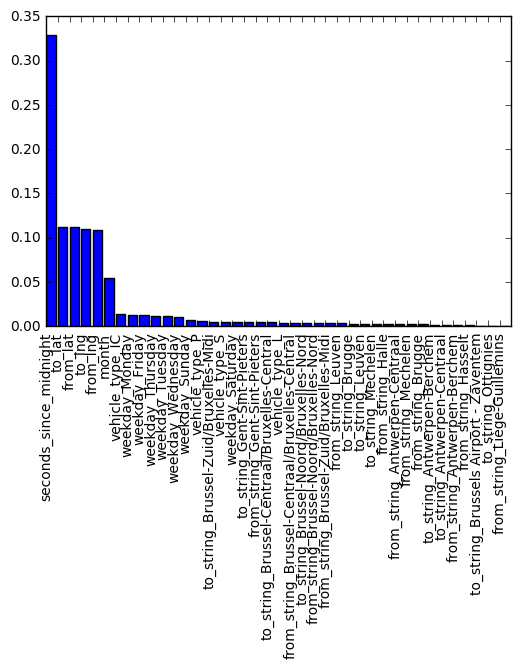

[[164  55  42]
 [ 66  77  43]
 [ 47  49  98]]
accuracy: 0.528861154446
Fold 2 / 5


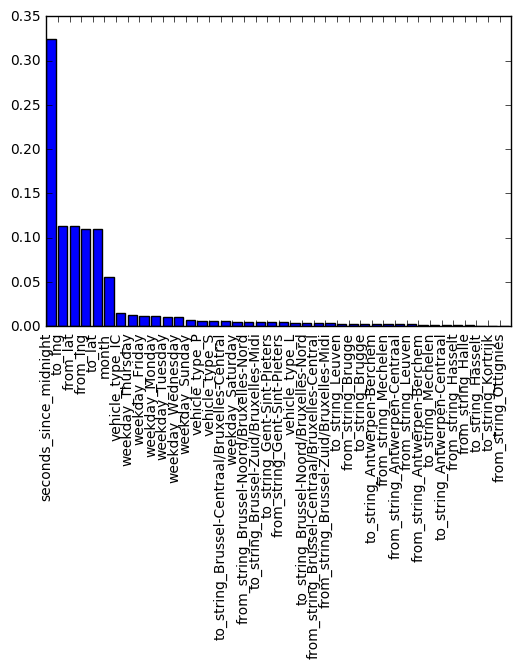

[[163  50  48]
 [ 69  60  57]
 [ 57  39  98]]
accuracy: 0.500780031201
Fold 3 / 5


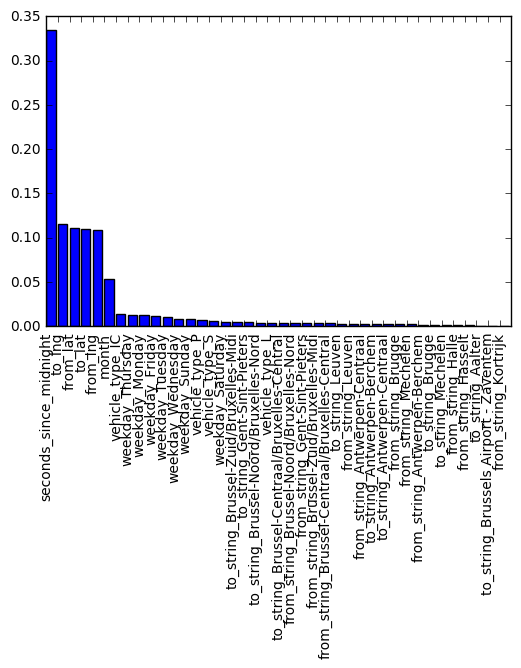

[[161  59  41]
 [ 60  77  49]
 [ 54  51  88]]
accuracy: 0.509375
Fold 4 / 5


KeyboardInterrupt: 

In [4]:
features_df = logs_df[['seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 
                       'month', 'from_lat', 'from_lng', 'to_lat', 'to_lng']]
features_df = pd.get_dummies(features_df, columns=['weekday', 'from_string', 'to_string', 'vehicle_type'])
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = logs_df['occupancy'].map(occupancy_mapping) 

xgb = XGBClassifier(learning_rate=0.15, n_estimators=500,
                     gamma=0.25, subsample=0.75, colsample_bytree=0.7,
                     nthread=1, reg_lambda=0.25,
                     min_child_weight=5, max_depth=9, objective='multi:softprob')

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)
accuracies = []
accuracies_no_drukte = []
for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    train = X_train.copy()
    train[y_train.name] = y_train
    
    
    #xgb = construct_classifier(train, X_train.columns, y_train.name)
    xgb.fit(X_train, y_train)
    selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    accuracy = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
    print('accuracy:', accuracy)
    accuracies.append(accuracy)
    
    
print('Avg accuracy:', np.mean(accuracies))
print('Avg accuracy no drukte:', np.mean(accuracies_no_drukte))

In [3]:
# Load all connections data
import glob
files = glob.glob('connections/data0810/*.json')
"""
            "departureStop": "http://irail.be/stations/NMBS/008821071", 
            "departureTime": "2016-07-31T22:23:00.000Z", 
            "departureDelay": 1260, 
            "gtfs:trip": "http://irail.be/trips/L257314091", 
            "arrivalStop": "http://irail.be/stations/NMBS/008821543", 
            "gtfs:route": "http://irail.be/vehicle/L2573", 
            "arrivalDelay": 1260, 
            "arrivalTime": "2016-07-31T22:23:00.000Z", 
            "@id": "http://irail.be/connections/8821071/20160801/L2573", 
            "@type": "Connection"
"""
connection_vectors = []
_columns = ['trip_id', 'vehicle', 'from_station', 'departure_time', 'departure_delay',
            'to_station', 'arrival_time', 'arrival_delay', 'connection_id', 'year', 'month', 'day']
for i,file in enumerate(files):
    print(i,'/',len(files))
    with open(file) as json_data:
        connection_json = json.load(json_data)
        for stop in connection_json["@graph"]:
            trip_id = stop['gtfs:trip']
            vehicle_name = stop['gtfs:route'].split('/')[-1]
            from_station_id = stop['departureStop'].split('/')[-1]
            departure_time = parse(stop['departureTime'])
            year = departure_time.year
            month = departure_time.month
            day = departure_time.day
            if 'departureDelay' in stop:
                departure_delay = stop['departureDelay']
            else:
                departure_delay = 0
            to_station_id = stop['arrivalStop'].split('/')[-1]
            arrival_time = parse(stop['arrivalTime'])
            if 'arrivalDelay' in stop:
                arrival_delay = stop['arrivalDelay']
            else:
                arrival_delay = 0
            connection_id = stop['@id']
            
            connection_vectors.append([trip_id, vehicle_name, from_station_id, departure_time,
                                       departure_delay, to_station_id, arrival_time, arrival_delay,
                                       connection_id, year, month, day])
connections_df = pd.DataFrame(connection_vectors)
connections_df.columns = _columns

0 / 17528
1 / 17528
2 / 17528
3 / 17528
4 / 17528
5 / 17528
6 / 17528
7 / 17528
8 / 17528
9 / 17528
10 / 17528
11 / 17528
12 / 17528
13 / 17528
14 / 17528
15 / 17528
16 / 17528
17 / 17528
18 / 17528
19 / 17528
20 / 17528
21 / 17528
22 / 17528
23 / 17528
24 / 17528
25 / 17528
26 / 17528
27 / 17528
28 / 17528
29 / 17528
30 / 17528
31 / 17528
32 / 17528
33 / 17528
34 / 17528
35 / 17528
36 / 17528
37 / 17528
38 / 17528
39 / 17528
40 / 17528
41 / 17528
42 / 17528
43 / 17528
44 / 17528
45 / 17528
46 / 17528
47 / 17528
48 / 17528
49 / 17528
50 / 17528
51 / 17528
52 / 17528
53 / 17528
54 / 17528
55 / 17528
56 / 17528
57 / 17528
58 / 17528
59 / 17528
60 / 17528
61 / 17528
62 / 17528
63 / 17528
64 / 17528
65 / 17528
66 / 17528
67 / 17528
68 / 17528
69 / 17528
70 / 17528
71 / 17528
72 / 17528
73 / 17528
74 / 17528
75 / 17528
76 / 17528
77 / 17528
78 / 17528
79 / 17528
80 / 17528
81 / 17528
82 / 17528
83 / 17528
84 / 17528
85 / 17528
86 / 17528
87 / 17528
88 / 17528
89 / 17528
90 / 17528
91 / 1752

In [7]:
URL_ROOT = 'http://graph.spitsgids.be/connections/?departureTime='
START = datetime.datetime(2016, 12, 1, 1, 0, 0)
END = datetime.datetime(2016, 12, 19, 0, 0, 0)
def retrieve_schedule(url_root, start, end, folder):
    current = start
    while current < end:
        ts = current.strftime('%Y-%m-%dT%H:%M')
        url = url_root + urllib.parse.quote(ts)
        response = requests.get(url)
        if response.ok:
            data = json.loads(str(response.content)[2:-1])
            filename = path.join(folder, ts + '.json')
            with open(filename, 'w') as outfile:
                json.dump(data, outfile, indent=4)
            print('%s stored' % url)
        else:
            print('%s failed' % url)

        current = current + datetime.timedelta(minutes=10)
retrieve_schedule(URL_ROOT, start=START, end=END, folder='connections/data0810')


http://graph.spitsgids.be/connections/?departureTime=2016-12-01T01%3A00 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T01%3A10 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T01%3A20 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T01%3A30 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T01%3A40 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T01%3A50 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T02%3A00 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T02%3A10 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T02%3A20 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T02%3A30 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T02%3A40 stored
http://graph.spitsgids.be/connections/?departureTime=2016-12-01T02%3A50 stored
http://graph.spitsgids.be/connections/?departureTime

In [6]:
# For each entry in the occupancy_df, filter out entries of the connections_df with:
# same vehicle number, same departure and same day/month
stations = np.unique(stations_df['URI'].values)
distance_feature_vectors = []
for i in range(len(logs_df)):
    print(str(i+1), '/', str(len(logs_df)))
    entry = logs_df.iloc[i,:]
    entry_station = entry['from']
    entry_time = entry['querytime']
    distances = {}
    for station in stations: distances[station] = None
    connections_entry = connections_df[(connections_df.from_station == entry['from'])
                                      & (connections_df.vehicle == entry['vehicle'])
                                      & (connections_df.year == entry['year'])
                                      & (connections_df.month == entry['month'])
                                      & (connections_df.day == entry['day'])]
    trip_id = None
    if len(connections_entry) > 0: 
        connections_entry = connections_entry.iloc[0,:]
        trip_id = connections_entry['trip_id']
    else: 
        print('Fault occured')
        
    if trip_id is not None:
        year_str = str(entry['year'])
        month_str = '0'+str(entry['month']) if entry['month'] < 10 else str(entry['month'])
        day_str = '0'+str(entry['day']) if entry['day'] < 10 else str(entry['day'])
        filtered_connections_stations = list(connections_df[(connections_df.connection_id.str.contains(year_str+
                                                                                                       month_str+
                                                                                                       day_str+
                                                                                                       '/'+entry['vehicle']))
                                                           & (connections_df.year == entry['year'])
                                                           & (connections_df.month == entry['month'])
                                                           & (connections_df.day == entry['day'])].sort_values(by='departure_time')['from_station'].values)
        print(year_str+month_str+day_str+'/'+entry['vehicle'],
              len(filtered_connections_stations))
        
        #if trip_id.split('/')[-1] != '':
        if entry_station in filtered_connections_stations:
            for station in filtered_connections_stations:
                #print(filtered_connections_stations.index(station) - filtered_connections_stations.index(entry_station))
                distances[station] = filtered_connections_stations.index(station) - filtered_connections_stations.index(entry_station)

            distances['time'] = entry_time
            distances['from_station'] = entry_station
            distance_feature_vectors.append({**distances, **entry.to_dict()})
        #else:
        #    print('wrong trip id')
        
distance_df = pd.DataFrame(distance_feature_vectors)

# --> Take the trip_id and filter out same trip_id on same day

# Create distance matrix and from this, create features

1 / 1926
Fault occured
2 / 1926
Fault occured
3 / 1926
20160927/IC1504 14
4 / 1926
20161020/IC1506 16
5 / 1926
20161020/IC1506 16
6 / 1926
20160802/IC1506 16
7 / 1926
20161006/IC1506 15
8 / 1926
20161011/IC1506 15
9 / 1926
20160920/IC1506 16
10 / 1926
20160927/IC1506 15
11 / 1926
20161016/IC1507 15
12 / 1926
20160929/IC1507 15
13 / 1926
20160922/IC1507 15
14 / 1926
20161024/IC1507 16
15 / 1926
20160812/IC1507 16
16 / 1926
20160922/IC1507 15
17 / 1926
20161022/IC1507 16
18 / 1926
20161013/IC1507 15
19 / 1926
20160922/IC1507 15
20 / 1926
20161023/IC1507 16
21 / 1926
20160927/IC1507 15
22 / 1926
20160728/IC1507 16
23 / 1926
20161011/IC1508 15
24 / 1926
20161021/IC1508 16
25 / 1926
20160917/IC1508 16
26 / 1926
20161005/IC1508 15
27 / 1926
20160917/IC1509 16
28 / 1926
20160730/IC1509 16
29 / 1926
20161029/IC1510 16
30 / 1926
20160906/IC1511 13
31 / 1926
20161005/IC1512 15
32 / 1926
20161021/IC1512 16
33 / 1926
20160930/IC1512 15
34 / 1926
20160821/IC1512 16
35 / 1926
20160930/IC1513 15
36 /

In [8]:
#print(sorted(map(lambda x: (pd.Timestamp(x).day, pd.Timestamp(x).month,
#                            pd.Timestamp(x).hour, pd.Timestamp(x).minute), 
#                 connections_df[connections_df.vehicle == 'IC826']['arrival_time'].values)))
print(len(distance_df))
distance_df.to_csv('distance_df.csv')

1852


In [21]:
print(distance_df.head(5))
frequencies = {}
stations = np.unique(stations_df['URI'].values)
for station in stations:
    frequencies[station] = len(distance_df[distance_df[station] >= 0])

  007015400 007015440  008008094  008010053 008010184  008010316 008011068  \
0      None      None        NaN        NaN      None        NaN      None   
1      None      None        NaN        NaN      None        NaN      None   
2      None      None        NaN        NaN      None        NaN      None   
3      None      None        NaN        NaN      None        NaN      None   
4      None      None        NaN        NaN      None        NaN      None   

   008011090  008015345  008015458  ...  seconds_since_midnight  \
0        NaN        NaN        NaN  ...                   84016   
1        NaN        NaN        NaN  ...                   29513   
2        NaN        NaN        NaN  ...                   33999   
3        NaN        NaN        NaN  ...                   49988   
4        NaN        NaN        NaN  ...                   28007   

                       time         to     to_lat    to_lng  \
0 2016-09-27 23:20:16+02:00  008831005  50.930822  5.327627   
1 

In [25]:
print(max(frequencies.values()))
stations = np.unique(stations_df['URI'].values)
new_columns = list(set(distance_df.columns) - set(stations))
distance_feature_vectors = []
for i in range(len(distance_df)):
    entry = distance_df.iloc[i,:]
    absolute_freq, weighted_freq, am_weighted_freq = 0, 0, 0
    for station in stations:
        if entry[station] is not None and entry[station] >= 0:
            absolute_freq += frequencies[station]
            w_freq = (frequencies[station] / max(abs(entry[station]), 1)) * np.sign(entry[station]) 
            weighted_freq += w_freq 
            if entry['hour'] < 12: am_weighted_freq += w_freq
            else: am_weighted_freq -= w_freq
                
    print(absolute_freq, weighted_freq, am_weighted_freq)
    distance_feature_vector = []
    for column in new_columns: 
        distance_feature_vector.append(entry[column])
    distance_feature_vector.append(absolute_freq)
    distance_feature_vector.append(weighted_freq)
    distance_feature_vector.append(am_weighted_freq)
    distance_feature_vectors.append(distance_feature_vector)
distance_feature_df = pd.DataFrame(distance_feature_vectors)
distance_feature_df.columns = new_columns + ['absolute_freq', 'weighted_freq', 'am_weighted_freq']
distance_feature_df.to_csv('distance_feature_df.csv')

855
487 210.75 -210.75
3637 1508.94599567 1508.94599567
530 219.35 219.35
4221 1660.45753968 -1660.45753968
4178 1656.87420635 1656.87420635
4178 1656.87420635 1656.87420635
4221 1660.45753968 1660.45753968
4178 1656.87420635 1656.87420635
1164 324.983333333 -324.983333333
1164 324.983333333 -324.983333333
4568 1196.65572483 1196.65572483
4611 1199.7271534 1199.7271534
4349 1624.74622045 1624.74622045
4306 1621.43852814 1621.43852814
4349 1624.74622045 1624.74622045
4178 1656.87420635 1656.87420635
4178 1656.87420635 1656.87420635
4221 1662.49559885 -1662.49559885
4178 1656.87420635 1656.87420635
4221 1660.45753968 1660.45753968
487 210.75 -210.75
1207 330.358333333 330.358333333
4611 1199.7271534 -1199.7271534
4306 1621.43852814 1621.43852814
3637 1508.94599567 1508.94599567
4221 1660.45753968 1660.45753968
4349 1624.74622045 1624.74622045
4413 1184.23264791 -1184.23264791
2019 599.501190476 -599.501190476
355 130.833333333 -130.833333333
312 116.5 -116.5
4349 1624.74622045 -1624.7462

Features dataframe dimensions: 1852 x 498
Fold 1 / 5


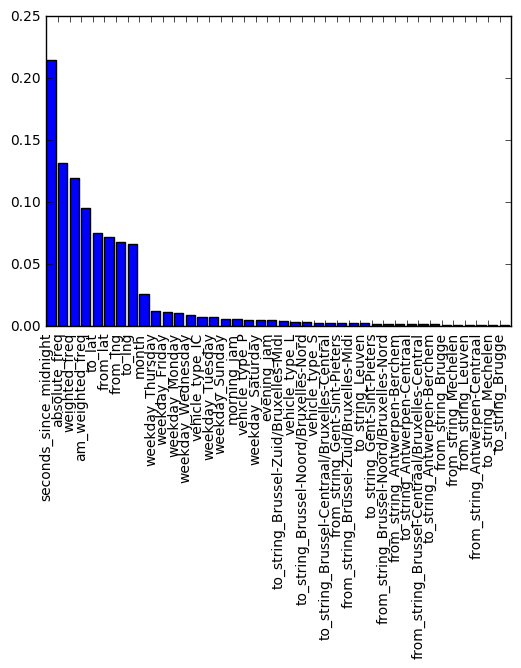

[[97 30 25]
 [34 44 28]
 [24 32 58]]
accuracy: 0.534946236559
Fold 2 / 5


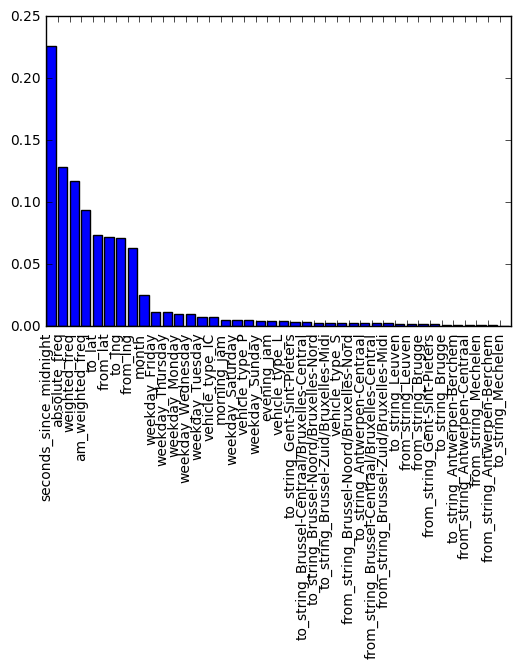

[[91 34 27]
 [35 46 25]
 [33 29 52]]
accuracy: 0.508064516129
Fold 3 / 5


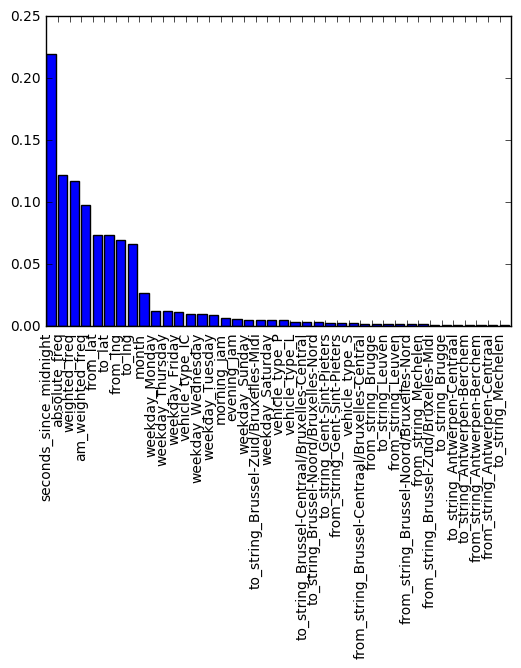

[[106  24  22]
 [ 36  37  32]
 [ 38  23  52]]
accuracy: 0.527027027027
Fold 4 / 5


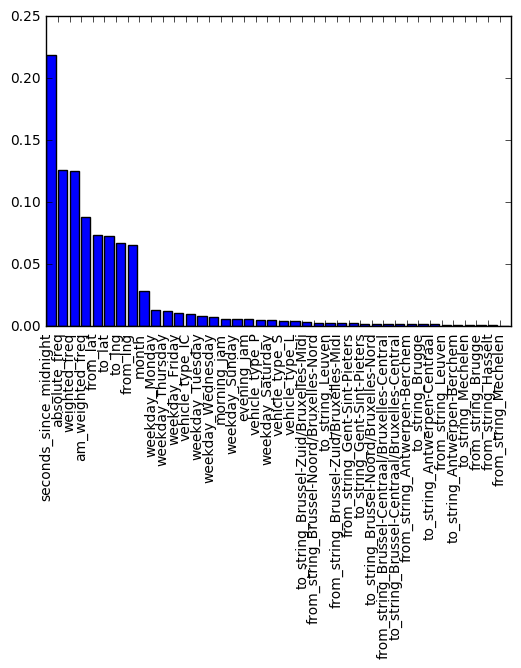

[[111  21  19]
 [ 34  40  31]
 [ 36  23  54]]
accuracy: 0.555555555556
Fold 5 / 5


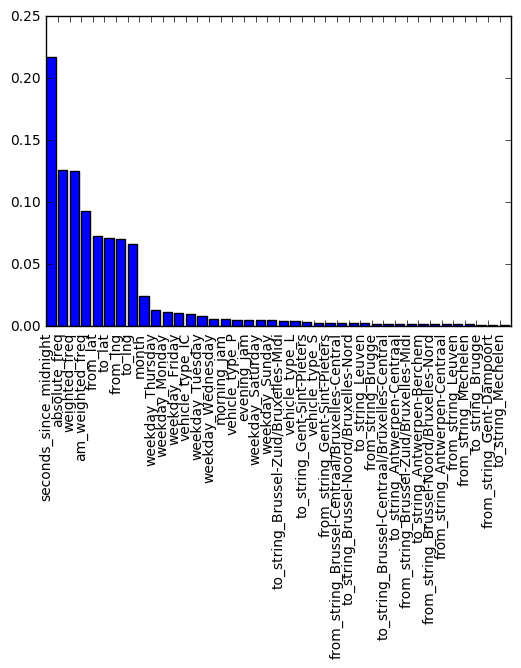

[[101  20  30]
 [ 40  40  25]
 [ 27  24  62]]
accuracy: 0.550135501355


In [27]:
# Maybe we should use only from_station, from_lat and from_lng? the to_ features seem somewhat unimportant? 
# We want to predict if the train will be full when the user gets on
features_df = distance_feature_df[['seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 
                                   'month', 'from_lat', 'from_lng', 'to_lat', 'to_lng',
                                   'absolute_freq', 'weighted_freq', 'am_weighted_freq', 'evening_jam',
                                   'morning_jam']]
features_df = pd.get_dummies(features_df, columns=['weekday','from_string', 'to_string', 'vehicle_type'])
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = distance_feature_df['occupancy'].map(occupancy_mapping)

xgb = XGBClassifier(learning_rate=0.075, n_estimators=1750,
                     gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                     nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                     min_child_weight=5, max_depth=13)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    
    xgb.fit(X_train, y_train)
    selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))

In [ ]:

distance_feature_df = pd.read_csv('distance_feature_df.csv')
features_df = distance_feature_df[['seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 
                                   'month', 'from_lat', 'from_lng', 'to_lat', 'to_lng',
                                   'absolute_freq', 'weighted_freq', 'am_weighted_freq', 'evening_jam',
                                   'morning_jam']]
features_df = pd.get_dummies(features_df, columns=['weekday','from_string', 'to_string', 'vehicle_type'])
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = distance_feature_df['occupancy'].map(occupancy_mapping)

xgb = XGBClassifier(learning_rate=0.075, n_estimators=1750,
                     gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                     nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                     min_child_weight=5, max_depth=13)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    
    params = {'n_neighbors':[3,5,10], 'algorithm': ['auto', 'ball_tree', 'kd_tree']}
    knn = GridSearchCV(KNeighborsClassifier() ,params, refit='True', n_jobs=1, cv=5)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy KNN:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    predictions = lda.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy LDA:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
    #params = {'C':[1,5,0.1,0.01],'gamma':[0.05,0.5,1], 'kernel': ['rbf', 'linear', 'poly']}
    #svc = GridSearchCV(SVC() ,params, refit='True', n_jobs=1, cv=5)
    #svc.fit(X_train, y_train)
    #predictions = svc.predict(X_test)
    #conf_matrix = confusion_matrix(y_test, predictions)
    #print(conf_matrix)
    #print('accuracy SVM:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    

In [44]:
distance_feature_df = pd.read_csv('distance_feature_df.csv')
print(len(distance_feature_df))
weather_delay_events_feature_df = pd.read_csv('weather_delay_features.csv')
feature_df = pd.merge(distance_feature_df, weather_delay_events_feature_df, how='left', 
                      on=['querytime', 'vehicle'])
feature_df.dropna(subset=['temperature_to'], inplace=True)
feature_df.drop_duplicates(subset=['time', 'vehicle'], inplace=True)
print(len(feature_df))
print(list(feature_df.columns))
__columns = ['querytime', 'seconds_since_midnight_x', 'morning_jam', 'from_lng_x', 'day', 'to_lng_x',
            'connection', 'evening_jam', 'vehicle_type_x', 'occupancy_x', 'to_lat_x', 'year', 
            'weekday_x', 'vehicle', 'from_lat_x', 'from_string_x', 'month_x', 'hour', 'to_string_x', 
            'absolute_freq', 'weighted_freq', 'am_weighted_freq', 'temperature_from', 'humidity_from', 
            'windspeed_from', 'visibility_from', 'weather_type_from', 'temperature_to', 'humidity_to', 
            'windspeed_to', 'visibility_to', 'weather_type_to', 'delay_15', 'delay_30', 'delay_60', 
            'delay_100']
for col in __columns:
    if col not in list(feature_df.columns): print(col)
feature_df = feature_df[__columns]
feature_df.to_csv('distance_weather_delay.csv')

1852
1845
['Unnamed: 0_x', 'time', 'seconds_since_midnight_x', 'morning_jam', 'from_lng_x', 'day', 'to_lng_x', 'connection', 'evening_jam', 'vehicle_type_x', 'to', 'querytime', 'from', 'occupancy_x', 'to_lat_x', 'year', 'index', 'weekday_x', 'vehicle', 'quarter', 'from_lat_x', 'from_string_x', 'from_station', 'month_x', 'hour', 'to_string_x', 'absolute_freq', 'weighted_freq', 'am_weighted_freq', 'Unnamed: 0_y', 'Unnamed: 0.1', 'seconds_since_midnight_y', 'weekday_y', 'from_string_y', 'to_string_y', 'vehicle_type_y', 'month_y', 'from_lat_y', 'from_lng_y', 'to_lat_y', 'to_lng_y', 'occupancy_y', 'temperature_from', 'humidity_from', 'windspeed_from', 'visibility_from', 'weather_type_from', 'temperature_to', 'humidity_to', 'windspeed_to', 'visibility_to', 'weather_type_to', 'delay_15', 'delay_30', 'delay_60', 'delay_100']


Features dataframe dimensions: 1845 x 544
Fold 1 / 5
(1475, 18)


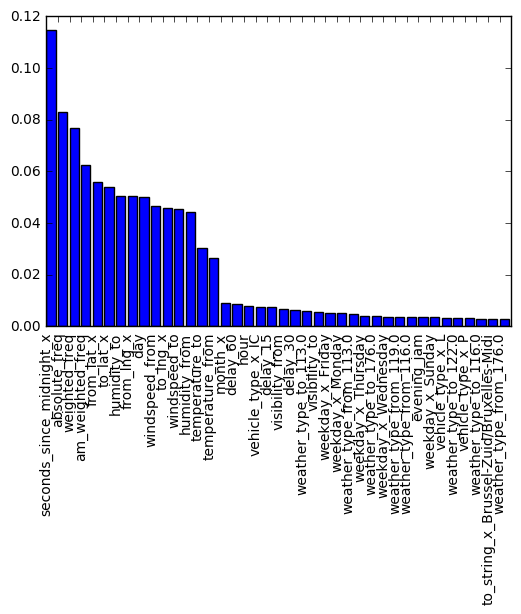

[[98 21 32]
 [39 28 39]
 [25 29 59]]
accuracy: 0.5


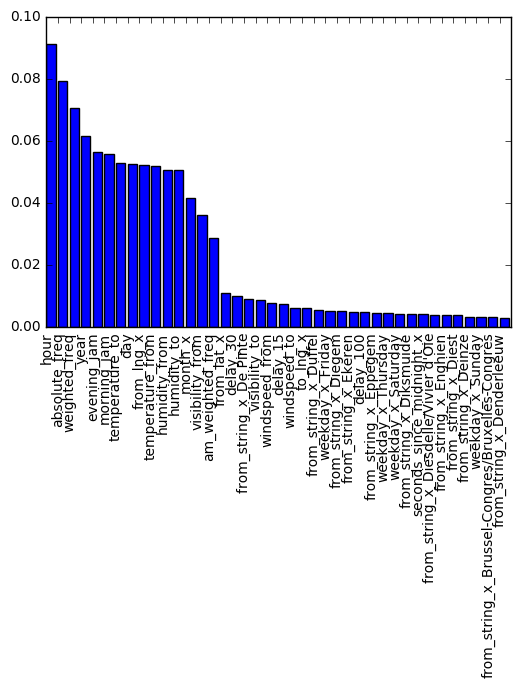

[[100  22  29]
 [ 36  31  39]
 [ 29  28  56]]
accuracy FS: 0.505405405405
Fold 2 / 5
(1475, 18)


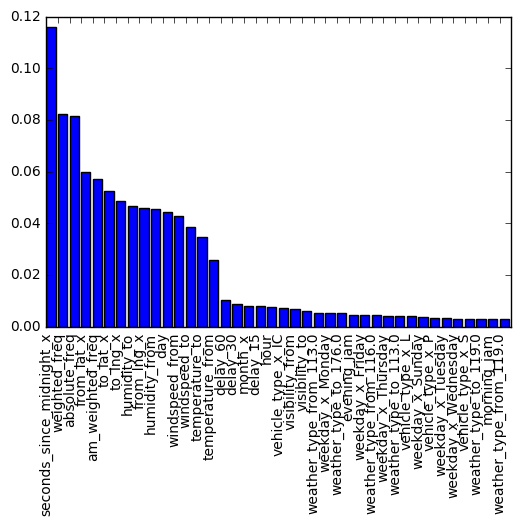

[[105  21  25]
 [ 38  39  28]
 [ 37  22  54]]
accuracy: 0.536585365854


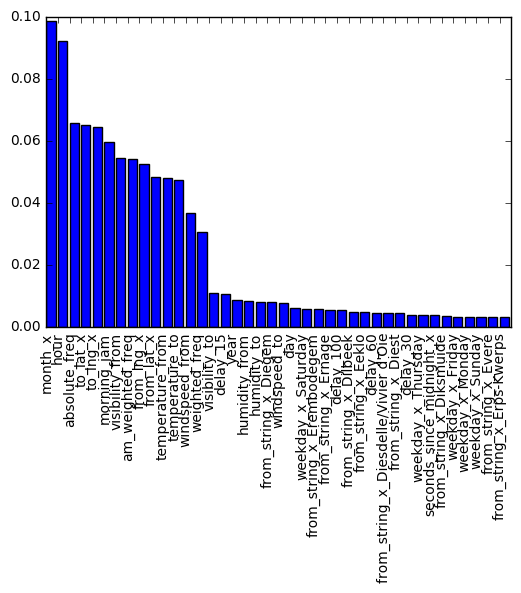

[[104  19  28]
 [ 34  39  32]
 [ 33  23  57]]
accuracy FS: 0.542005420054
Fold 3 / 5
(1475, 18)


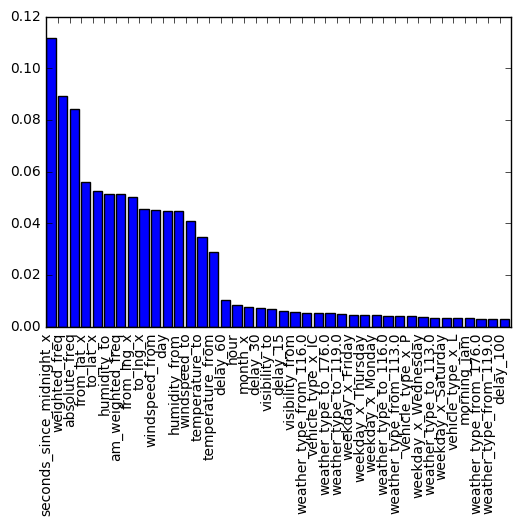

[[114  21  16]
 [ 37  41  27]
 [ 23  34  56]]
accuracy: 0.571815718157


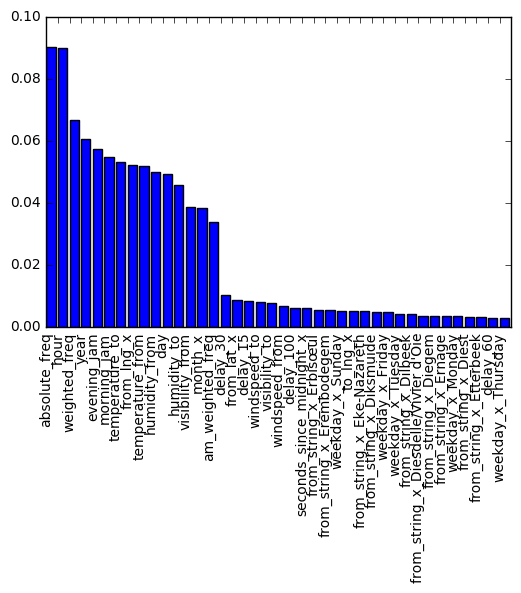

[[110  23  18]
 [ 33  43  29]
 [ 27  29  57]]
accuracy FS: 0.569105691057
Fold 4 / 5
(1475, 18)


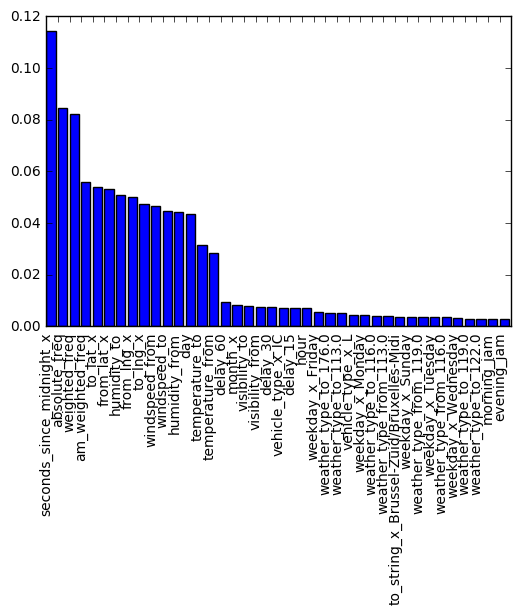

[[106  31  14]
 [ 30  47  28]
 [ 26  30  57]]
accuracy: 0.569105691057


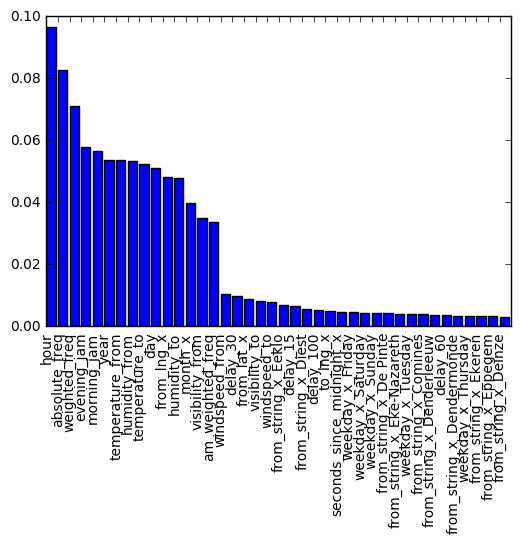

[[102  33  16]
 [ 32  43  30]
 [ 25  32  56]]
accuracy FS: 0.544715447154
Fold 5 / 5
(1475, 18)


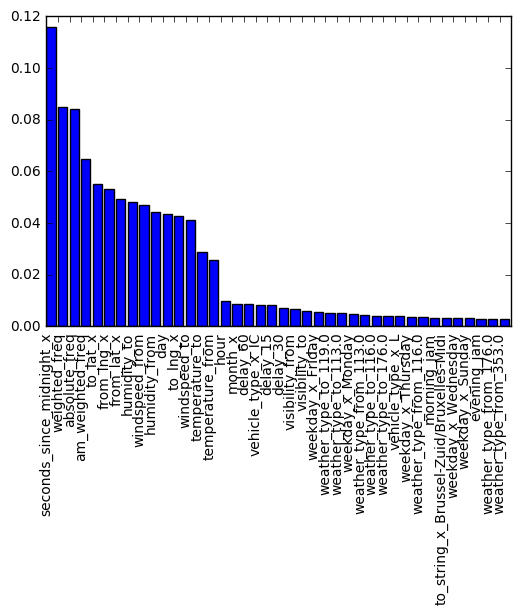

[[94 30 27]
 [35 45 25]
 [26 27 59]]
accuracy: 0.538043478261


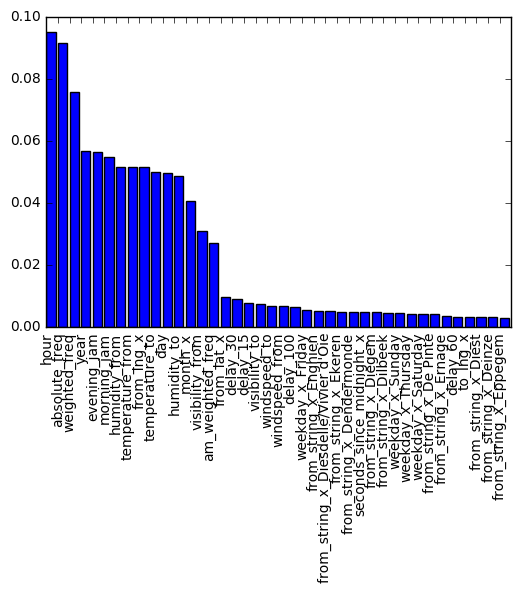

[[93 33 25]
 [37 39 29]
 [25 31 56]]
accuracy FS: 0.510869565217
Mean accuracy = 0.543110050666
Mean accuracy FS = 0.534420305778


In [60]:
# Maybe we should use only from_station, from_lat and from_lng? the to_ features seem somewhat unimportant? 
# We want to predict if the train will be full when the user gets on
features_df = pd.read_csv('distance_weather_delay.csv')
features_df = features_df.drop(['connection', 'vehicle', 'querytime', 'Unnamed: 0'], axis=1)
features_df = pd.get_dummies(features_df, columns=['weekday_x','from_string_x', 'to_string_x', 'vehicle_type_x',
                                                   'weather_type_to', 'weather_type_from'])
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = features_df['occupancy_x'].map(occupancy_mapping)
features_df = features_df.drop(['occupancy_x'], axis=1)

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

xgb = XGBClassifier(learning_rate=0.075, n_estimators=1750,
                     gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                     nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                     min_child_weight=5, max_depth=13)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

accuracies = []
accuracies_fs = []
for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)

    lsvc = LinearSVC(C=0.05, penalty="l1", dual=False).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True)
    X_train_fs = model.transform(X_train)
    X_test_fs = model.transform(X_test)
    print(X_new.shape)
    
    xgb.fit(X_train, y_train)
    selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    acc = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
    print('accuracy:', acc)
    accuracies.append(acc)
    
    xgb.fit(X_train_fs, y_train)
    selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test_fs)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    acc = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
    print('accuracy FS:', acc)
    accuracies_fs.append(acc)
    
print('Mean accuracy =', np.mean(accuracies))
print('Mean accuracy FS =', np.mean(accuracies_fs))

## TODO: How long ago did a train leave, the distance_features but with drukte instead of frequency in data